# Предсказание рейтинга и полярности отзывов к фильмам

Набор данных, использованный в данной задаче, может быть найден по ссылке http://ai.stanford.edu/~amaas//data/sentiment/ .

В нем содержится коллеция из 50.000 отзывов к фильмам, взятых с IMDB, разделенная равномерно на 25.000 обучающих и 25.000 тестовых экземпляров. Каждому отзыву соответсвует полярность (0 - отрицательный, 1 - положительный) и рейтинг (от 1 до 4 (вкл. границы диапазона) для отрицательных и от 7 до 10 для положительных). Отзывы с рейтингами 5 и 6 считаются нейтральными и НЕ ВКЛЮЧЕНЫ в этот набор данных.

Также датасет включает в себя 50.000 неразмеченыных отзывов, т.е. отзывов, у которых нет рейтинга и полярности. Таким отзывам присвоен рейтинг 0.

In [1]:
# data extraction
import tarfile
import os

import pandas as pd
import numpy as np

# data preprocessing
import json
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

# vectorizers
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import plot_confusion_matrix

# for model saving
import joblib

# Загрузка данных

In [2]:
# extract data if required

# data_tar = tarfile.open('data/aclImdb_v1.tar.gz', mode='r:gz')
# data_tar.extractall('data/')

In [3]:
DATA_PATH = 'data/aclImdb'

def load_data(path=DATA_PATH):
    data_dict = {'text': [], 'sample_type': [], 'rating': [], 'polarity': []}

    for sample_type in ['train', 'test']:
        current_sample_path = os.path.join(path, sample_type)

        for polarity in ['pos', 'neg']:
            current_sample_polarity_path = os.path.join(current_sample_path, polarity)

            for entry in os.scandir(current_sample_polarity_path):
                with open(os.path.join(current_sample_polarity_path, entry.name),
                         'r', encoding='utf-8') as review_file:

                    data_dict['text'].append(review_file.read())
                    data_dict['sample_type'].append(sample_type)
                    
                    filename = entry.name.split('.')[0] # without file format
                    rating = filename.split('_')[1]
                    data_dict['rating'].append(rating)

                    data_dict['polarity'].append(1 if polarity == 'pos' else 0)

    
    return pd.DataFrame(data_dict)

In [4]:
# if required for something like training word2vec

UNSUPERVISED_DATA_PATH = os.path.join(DATA_PATH, 'train/unsup')

def load_unsupervised_data(path=UNSUPERVISED_DATA_PATH):
    texts = []

    for entry in os.scandir(path):
        with open(os.path.join(UNSUPERVISED_DATA_PATH, entry.name),
                 'r', encoding='utf-8') as review_file:

                 texts.append(review_file.read())

    return texts

In [5]:
data = load_data(DATA_PATH)

In [6]:
# convert dtype of review's rating and polarity for ml and memory saving

data['rating'] = pd.to_numeric(data['rating'] ,downcast='unsigned')
data['polarity'] = pd.to_numeric(data['polarity'], downcast='unsigned')

In [7]:
data.head()

,text,sample_type,rating,polarity
0,Bromwell High is a cartoon comedy. It ran at t...,train,9,1
1,Homelessness (or Houselessness as George Carli...,train,8,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,train,10,1
3,This is easily the most underrated film inn th...,train,7,1
4,This is not the typical Mel Brooks film. It wa...,train,8,1


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         50000 non-null  object
 1   sample_type  50000 non-null  object
 2   rating       50000 non-null  uint8 
 3   polarity     50000 non-null  uint8 
dtypes: object(2), uint8(2)
memory usage: 879.0+ KB


In [9]:
# data shuffle
data = data.sample(frac=1)

In [10]:
data.head()

,text,sample_type,rating,polarity
23231,Eddie Murphy for best supporting actor??? What...,train,4,0
8560,I was drawn to this movie the moment I saw a p...,train,7,1
2920,Water Lilies is a well-made first film from Fr...,train,8,1
26850,In a world in which debatable and misunderstoo...,test,10,1
23956,What can you say about this movie? It was not ...,train,4,0


Для дальнейшего анализа важно знать распределение обучающей и тестовой выборки по рейтингам.

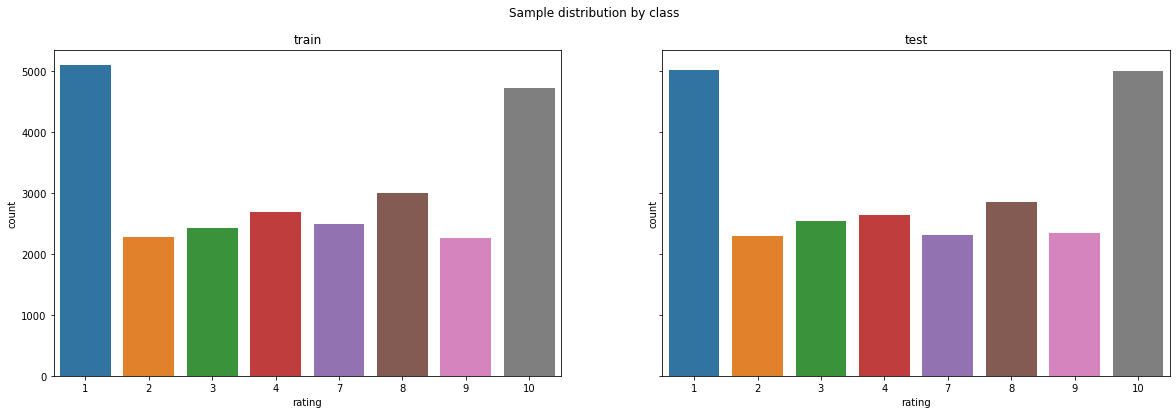

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2,
                        sharey=True, figsize=(20, 6))

axs[0].set_title('train')
axs[1].set_title('test')

sns.countplot(x='rating', data=data.loc[data.sample_type == 'train'], ax=axs[0])
sns.countplot(x='rating', data=data.loc[data.sample_type == 'test'], ax=axs[1])

fig.suptitle('Sample distribution by class')
plt.show()

По данному графику можно заметить, что в выборке доминируют отзывы "крайних" полярностей, а именно отзывы с рейтингами 1 и 10. Тем не менее, данную выборку можно считать сбалансированной.

# Предобработка данных

Текст - один из наиболее неструктурированных видов данных, поэтому он нуждается в предобработке. Но в данном случае проводить стандартную предобработку недопустимо, так как важно учитывать ЭМОЦИОНАЛЬНУЮ составляющую текста (например: смайлики, "кричащие выражения", отрицания и многое другое). В этой работе не проводилось какого-либо серьезного анализа эмоций, так как это отдельный вид задач и он требует особого подхода. Тем не менее, какие-то моменты были учтены, а именно:
- удаление стоп-слов (из словаря стоп-слов были исключены отрицания, так как они являются важной составляющей анализа эмоций...такие биграммы, как "not good" будут весомыми признаками для построенное модели)
- лемматизация и стемминг (не проводились, так как разные формы слов могут выражать разные эмоции)

В ходе анализа отзывов были обнаружены html-теги, "шумовые" символы (такие как: "////" и "....."), разные формы слов с апострофами (например: "isn't", "is not"). Все это было учтено и приведеное к стандартному виду.

In [12]:
def load_apostrophes_from_json(path):
    with open(path, 'r') as fin:
        return json.loads(fin.read())

In [13]:
print(load_apostrophes_from_json('apostrophes.json'))

{"aren't": 'are not', "can't": 'cannot', "couldn't": 'could not', "didn't": 'did not', "doesn't": 'does not', "don't": 'do not', "hadn't": 'had not', "hasn't": 'has not', "haven't": 'have not', "he'd": 'he would', "he'll": 'he will', "he's": 'he is', "i'd": 'I would', "i'll": 'I will', "i'm": 'I am', "isn't": 'is not', "it's": 'it is', "it'll": 'it will', "i've": 'I have', "let's": 'let us', "mightn't": 'might not', "mustn't": 'must not', "shan't": 'shall not', "she'd": 'she would', "she'll": 'she will', "she's": 'she is', "shouldn't": 'should not', "that's": 'that is', "there's": 'there is', "they'd": 'they would', "they'll": 'they will', "they're": 'they are', "they've": 'they have', "we'd": 'we would', "we're": 'we are', "weren't": 'were not', "we've": 'we have', "what'll": 'what will', "what're": 'what are', "what's": 'what is', "what've": 'what have', "where's": 'where is', "who'd": 'who would', "who'll": 'who will', "who're": 'who are', "who's": 'who is', "who've": 'who have', "w

In [14]:
def preprocessor(text):
    # remove html tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # remove noize
    text = re.sub('[^A-Za-z0-9\']', ' ', text)  
    text = re.sub('\s{2,}', ' ', text)

    text = text.lower()

    # convert apostrophes into standard lexicons
    apostrophes = load_apostrophes_from_json('apostrophes.json')
    reformed = [apostrophes[word] if word in apostrophes else word for word in text.split()]
    text = " ".join(reformed)

    # also convert 'cannot' into 'can not'
    text = re.sub('cannot', ' can not', text)

    # finally delete possessive cases and apostrophes
    text = re.sub('\'s', '', text)
    text = re.sub('\'', '', text)

    return text

In [15]:
from nltk.corpus import stopwords

negates = {'not', 'no', 'nor'}
stop_words = set(stopwords.words('english')) - negates

In [16]:
print(stop_words)

{'were', 'being', 'to', 'between', "doesn't", 'ourselves', 'i', 'further', 'doesn', 'that', 'can', "won't", 'will', "wasn't", 'any', 'their', 'the', 'wouldn', "isn't", 'where', 'you', 'am', 'himself', 'him', "wouldn't", 'wasn', 'he', "haven't", 'from', 'while', "needn't", 'for', "mightn't", "aren't", 'isn', "couldn't", 'below', 'these', 'what', 'm', "didn't", 'mightn', 'she', 'its', "shouldn't", 'myself', 'yourselves', "hadn't", 'again', 'than', 'now', 'they', 'during', 'should', 'won', "it's", 'ain', 'all', "hasn't", 'hadn', 're', 'down', 'under', 'which', 'because', "don't", 'o', 'other', 'both', 'with', 'haven', 'just', 'your', 'by', 'are', 'have', 'd', 'ours', 'a', 'this', 'up', 'couldn', 'shan', "weren't", 'very', 've', 'so', 'own', "that'll", 'his', 'don', 'when', 'same', 'theirs', 'weren', "you've", 'was', 'above', 'hasn', 'll', 'into', 'did', "you'll", 'had', 'then', 'do', 'as', 'on', 'why', 'only', 'didn', 'hers', 'or', 'is', 'me', 'aren', "should've", 'before', 'them', 'shoul

In [17]:
def word_tokenizer(text):
    return text.split()

# Векторизация и классификация текста

Для решения данной задачи, а именно - предсказание рейтинга отзывов к фильмам, взяты в сравнение два вида пайплайнов:
- Bag Of Words and Naive Bayes (NB_BOW)
- Tf-IDF and Logistic Regression (LR_TFIDF)

Пайплайны будут сравниваться на кросс-валидации с количеством фолдов равным 10. 

Основной метрикой качества классификации будет среднеквадратическая ошибка, так как важно учитывать не только сам факт ошибки модели, но еще и насколько сильно модель ошиблась в предсказанном рейтинге. Также в качестве метрик взяты: точность по рейтингу и точность по полярности.

Настраиваемые гиперпараметры моделей:
- ngram_range (будут рассматриваться значения: (1, 1), (1, 2) и (2, 2), то есть униграммы, биграммы и смесь униграмм и биграмм)
- max_df (количество наиболее часто встречающихся токенов в словаре, которое не будет рассматриваться в дальнейшем)
- max_features (количество токенов в словаре)
- C (параметр регуляризации для логистической регрессии)

Первые три параметра будут настроены на NB_BOW, так как Naive Bayes достаточно быстро обучается по сравнению с градиентными методами.

In [18]:
reviews_train = data.loc[data.sample_type == 'train']['text']
y_train = data.loc[data.sample_type == 'train']['rating']

reviews_test = data.loc[data.sample_type == 'test']['text']
y_test = data.loc[data.sample_type == 'test']['rating']

In [19]:
ngram_ranges = [(1, 2), (2, 2)]

In [20]:
def polarity_accuracy(y_true, y_pred):
    polarity_true = [1 if rating >=7 else 0 for rating in y_true]
    polarity_pred = [1 if rating >=7 else 0 for rating in y_pred]

    return accuracy_score(polarity_true, polarity_pred)

scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 
           'accuracy': 'accuracy', 
           'polarity_accuracy': make_scorer(polarity_accuracy)}

In [21]:
MAIN_METRIC = 'neg_mean_squared_error'

In [22]:
def get_best_estimator(texts_train, y_train, vectorizer, classifier, params, scoring, cv):
    pipe = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])

    grid_search = GridSearchCV(estimator=pipe, param_grid=params, 
                               scoring=scoring, refit=MAIN_METRIC,
                               cv=cv, n_jobs=-1)  
    
    grid_search.fit(texts_train, y_train)

    print('best parameters:', grid_search.best_params_)
    print('best ' + MAIN_METRIC, grid_search.best_score_)

    return grid_search

## Bag of words and Naive Bayes

In [23]:
count_vectorizer = CountVectorizer(lowercase=True,
                                   preprocessor=preprocessor,
                                   tokenizer=word_tokenizer,
                                   stop_words=stop_words)

Фиксация параметров max_df и max_features => оптимизация ngram_range:

In [24]:
nb_params = {'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], 
             'vectorizer__max_df': [0.95], 
             'vectorizer__max_features': [5000]}

In [25]:
%%time
nb_bow_gs = get_best_estimator(reviews_train, y_train, 
                               count_vectorizer, MultinomialNB(), 
                               params=nb_params, scoring=scoring, cv=10)

best parameters: {'vectorizer__max_df': 0.95, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 2)}
best neg_mean_squared_error -6.20732
Wall time: 4min 7s


Результат ожидаемый, так как для данной задачи информативны как униграммы, так и биграммы. Теперь параметр ngram_range принимает значение (1, 2).

Фиксация ngram_range и max_df => оптимизация max_features:

In [26]:
nb_params = {'vectorizer__ngram_range': [(1, 2)], 
             'vectorizer__max_df': [0.95], 
             'vectorizer__max_features': [5000, 7000, 10000, 15000, 17000, 20000]}

In [27]:
%%time
nb_bow_gs = get_best_estimator(reviews_train, y_train, 
                               count_vectorizer, MultinomialNB(), 
                               params=nb_params, scoring=scoring, cv=10)

best parameters: {'vectorizer__max_df': 0.95, 'vectorizer__max_features': 20000, 'vectorizer__ngram_range': (1, 2)}
best neg_mean_squared_error -5.83524
Wall time: 12min 18s


Наблюдается явное улучшение значения скоринговой функции. Параметр max_features теперь равен 17.000.

Фиксация ngram_range и max_features => оптимизация max_df:

In [28]:
nb_params = {'vectorizer__ngram_range': [(1, 2)], 
             'vectorizer__max_df': [0.99, 0.97, 0.95, 0.93, 0.90], 
             'vectorizer__max_features': [17000]}

In [29]:
%%time
nb_bow_gs = get_best_estimator(reviews_train, y_train, 
                               count_vectorizer, MultinomialNB(), 
                               params=nb_params, scoring=scoring, cv=10)

best parameters: {'vectorizer__max_df': 0.99, 'vectorizer__max_features': 17000, 'vectorizer__ngram_range': (1, 2)}
best neg_mean_squared_error -5.8644
Wall time: 10min 9s


## Tf-Idf and Logistic Regression

In [30]:
tfidf_vectorizer = TfidfVectorizer(lowercase=True,
                                   preprocessor=preprocessor,
                                   tokenizer=word_tokenizer,
                                   stop_words=stop_words,
                                   ngram_range=(1, 2),
                                   max_df=0.99,
                                   max_features=17000)

In [31]:
lr_params = {'classifier__C': [1.0, 2.0, 4.0, 6.0, 10.0]}

In [32]:
%%time
lr_tfidf_gs = get_best_estimator(reviews_train, y_train, 
                                 tfidf_vectorizer, LogisticRegression(), 
                                 params=lr_params, scoring=scoring, cv=10)

best parameters: {'classifier__C': 10.0}
best neg_mean_squared_error -5.20648
Wall time: 18min 13s
Parser   : 183 ms


# Сравнительный анализ результатов моделей на кросс-валидации

In [33]:
def get_cv_scores(grid_search):
    scores = []

    cv_results = grid_search.cv_results_
    best_index = grid_search.best_index_
    for score_name in grid_search.scoring.keys():
        scores.append(cv_results['mean_test_'+score_name][best_index])

    return scores

In [34]:
nb_bow_scores = get_cv_scores(nb_bow_gs)
lr_tfidf_scores = get_cv_scores(lr_tfidf_gs)

In [35]:
labels = list(scoring.keys())

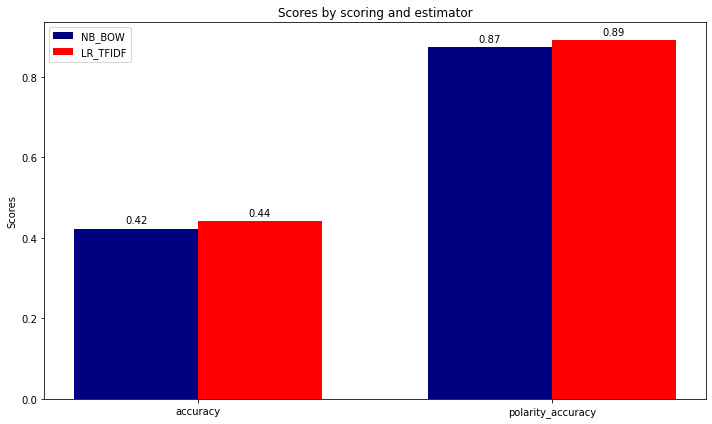

In [36]:
x = np.arange(2)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, nb_bow_scores[1:], width, label='NB_BOW', color='navy')
rects2 = ax.bar(x + width/2, lr_tfidf_scores[1:], width, label='LR_TFIDF', color='red')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by scoring and estimator')
ax.set_xticks(x)
ax.set_xticklabels(labels[1:])
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

По графику видно, что модель LR_TFIDF работает лучше на этих данных. Теперь нужно проверить ее на тестовой выборке.

# Анализ качества лучшей модели на тестовой выборке

In [37]:
y_pred = lr_tfidf_gs.predict(reviews_test)

In [38]:
print('mean_squared_error:', mean_squared_error(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred))
print('polarity_accuracy', polarity_accuracy(y_test, y_pred))

mean_squared_error: 5.49064
accuracy: 0.43676
polarity_accuracy 0.88232


Важно заметить, что модель на новых данных работает не хуже, чем на тех, которых обучалась.

Теперь для анализа ошибок построим соответсвующую матрицу.

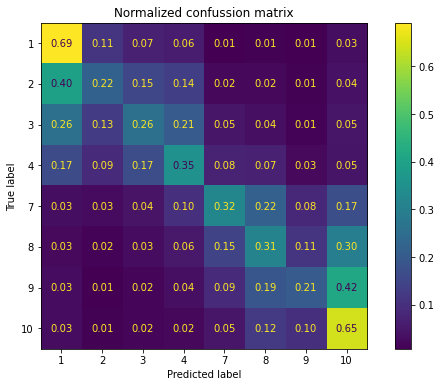

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

plot_confusion_matrix(lr_tfidf_gs, reviews_test, y_test, normalize='true', values_format='.2f', ax=ax)

plt.title('Normalized confussion matrix')
plt.show()

По данной матрице ошибок можно увидеть следующее:
- элементы на главной диагонали имеют самые большие значения по своим столбцам => у нас нет такой ситуации, что на каком-то из рейтингов модель сильно ошибается в пользу какого-то другого рейтинга
- по мере удаления от истинного рейтинга по столбцу, элементы матрицы принимают все меньшие значения => модель ошибается незначительно, то есть она все же предсказывает полярность отзыва, что наиболее важно
- чаще всего отрицательные и положительные отзывы относятся к рейтингам 1 и 10 соответсвенно...это связано с тем, что объектов в выборке с данными значениями рейтингов больше, чем остальных

In [40]:
# Save model

joblib.dump(lr_tfidf_gs.best_estimator_, 'ml/estimator.joblib', compress=True)

['ml/estimator.joblib']

# Итоги

В ходе данной работы была обучена модель, прогнозирующая рейтинг отзыва к фильму по тексту. 

Результаты на тестовых данных:
- среднеквадратичная ошибка  5.49
- точность                0.44
- точность полярности        0.88 

# Дальнейшая работа

Для улучшения качества классификации следует:
- добавить в предобработку текста извлечение важных признаков эмоций
- оптимизировать гиперпараметры моделей (требуется мощные многоядерные компьютеры)
- попробовать другие методы векторизации и классификации текста
- увеличить обучающую выборку